### Installing and importing required libraries

In [1]:
!pip install fastapi uvicorn pyngrok nest_asyncio requests transformers accelerate -q

In [3]:
!pip install mlflow -q

In [1]:
import os
import gc
import json
import math
import mlflow
import torch
from datetime import datetime
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    pipeline,
)
from peft import LoraConfig, get_peft_model
from accelerate import Accelerator
import matplotlib.pyplot as plt
import seaborn as sns

### Environment setup

In [2]:
# ==============================================================
# ENVIRONMENT SETUP
# ==============================================================
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["MLFLOW_TRACKING_URI"] = "https://f96dffc4d84a.ngrok-free.app" # This is a tunneled url from ngrok
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
accelerator = Accelerator()

In [3]:
# ==============================================================
# MEMORY UTILS
# ==============================================================
def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    gc.collect()

### Importing and processing data

Loading dataset from local JSON file...
Loaded 1497 samples from rows.json
Limiting dataset from 1497 to 1000 samples

🔎 Raw sample: {'product': 'Harem pants', 'description': 'A style of pants with a dropped crotch, loose-fitting legs, and a gathered waistband for a unique, bohemian look.', 'ad': 'Discover Harem Pants! Unique, stylish bohemian vibes with a dropped crotch & loose legs. Comfy meets chic - elevate your wardrobe. Limited stock - shop now!'}


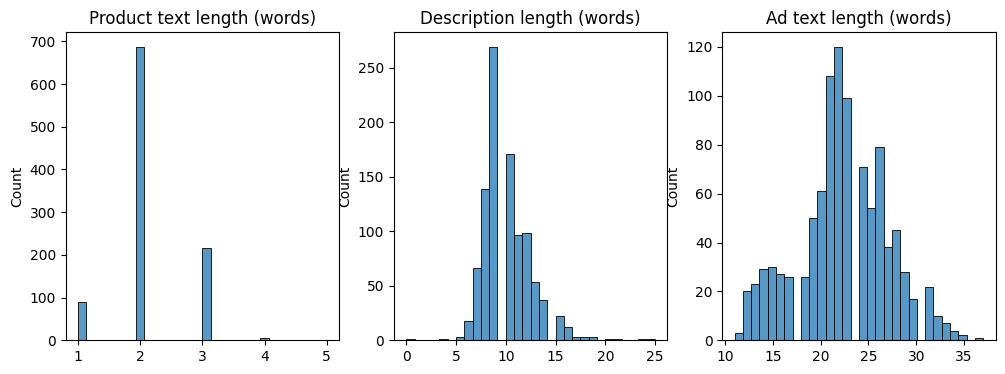

In [4]:
# ==============================================================
# LOAD DATASET FROM LOCAL JSON
# ==============================================================
json_file_path = "rows.json"
max_samples = 1500

print("Loading dataset from local JSON file...")
try:
    with open(json_file_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    rows = []
    for item in json_data:
        if 'row' in item:
            row_data = item['row']
            rows.append({
                'product': row_data.get('product', '').strip(),
                'description': row_data.get('description', '').strip(),
                'ad': row_data.get('ad', '').strip()
            })

    print(f"Loaded {len(rows)} samples from {json_file_path}")

    if len(rows) > max_samples:
        print(f"Limiting dataset from {len(rows)} to {max_samples} samples")
        rows = rows[:max_samples]

    raw_dataset = Dataset.from_list(rows)

    # ===== VISUALIZATION: RAW DATA =====
    print("\n🔎 Raw sample:", rows[0])
    product_lengths = [len(r["product"].split()) for r in rows]
    desc_lengths = [len(r["description"].split()) for r in rows]
    ad_lengths = [len(r["ad"].split()) for r in rows]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(product_lengths, bins=30, kde=False)
    plt.title("Product text length (words)")

    plt.subplot(1, 3, 2)
    sns.histplot(desc_lengths, bins=30, kde=False)
    plt.title("Description length (words)")

    plt.subplot(1, 3, 3)
    sns.histplot(ad_lengths, bins=30, kde=False)
    plt.title("Ad text length (words)")
    plt.show()

except FileNotFoundError:
    print(f"Error: Could not find {json_file_path} in the current directory")
    raise
except json.JSONDecodeError as e:
    print(f"Error: Invalid JSON format in {json_file_path}: {e}")
    raise

In [5]:
# ==============================================================
# SETUP TOKENIZER AND MODEL
# ==============================================================
model_name = "microsoft/Phi-3-mini-4k-instruct"
print("Setting up tokenizer and model...")
clear_memory()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use half precision for memory efficiency
    trust_remote_code=True,
    device_map="auto"  # Automatically handle device placement
)

# Enable gradient checkpointing for memory efficiency
if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()

Setting up tokenizer and model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
# ==============================================================
# SETUP LoRA
# ==============================================================
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # Phi-3 specific modules
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


🔎 Example formatted prompt:
 <|system|>
You are an expert marketing copywriter. Create engaging advertisements based on product information.
<|end|>
<|user|>
Product: Harem pants
Description: A style of pants with a dropped crotch, loose-fitting legs, and a gathered waistband for a unique, bohemian look.
Create an advertisement for this product.
<|end|>
<|assistant|>
Discover Harem Pants! Unique, stylish bohemian vibes with a dropped crotch & loose legs. Comfy meets chic - elevate your wardrobe. Limited stock - shop now!<|e ...


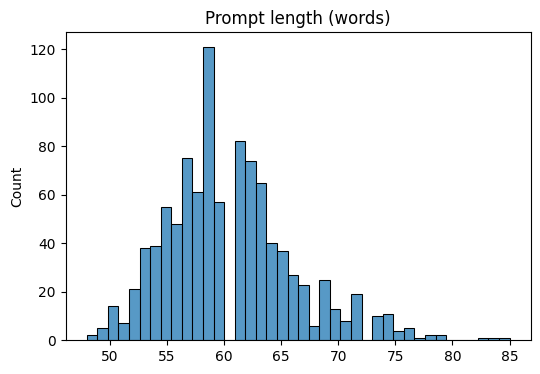

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
# ==============================================================
# PREPROCESS DATA
# ==============================================================
max_length = 512

def format_prompt(example):
    product = example.get("product", "").strip()
    description = example.get("description", "").strip()
    ad_text = example.get("ad", "").strip()

    if product is None: product = ""
    if description is None: description = ""
    if ad_text is None: ad_text = ""

    prompt = f"""<|system|>
You are an expert marketing copywriter. Create engaging advertisements based on product information.
<|end|>
<|user|>
Product: {product}
Description: {description}
Create an advertisement for this product.
<|end|>
<|assistant|>
{ad_text}<|end|>"""

    return {"text": prompt}

# ===== VISUALIZATION: FORMATTED DATA =====
formatted_data = raw_dataset.map(format_prompt, remove_columns=raw_dataset.column_names)
print("\n🔎 Example formatted prompt:\n", formatted_data[0]["text"][:500], "...")

prompt_lengths = [len(d["text"].split()) for d in formatted_data]
plt.figure(figsize=(6,4))
sns.histplot(prompt_lengths, bins=40, kde=False)
plt.title("Prompt length (words)")
plt.show()

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

processed_dataset = formatted_data.map(
    tokenize_function, batched=True, remove_columns=formatted_data.column_names
)


🔎 Tokenized sample (first 30 tokens):
[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000]


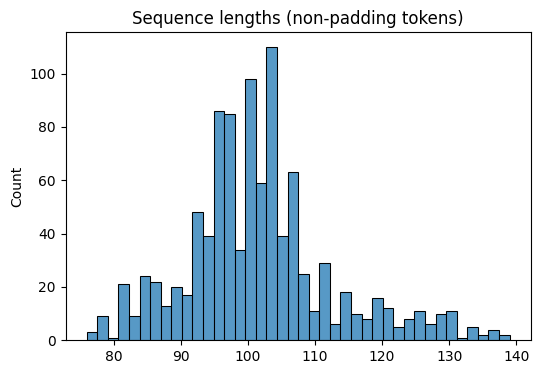

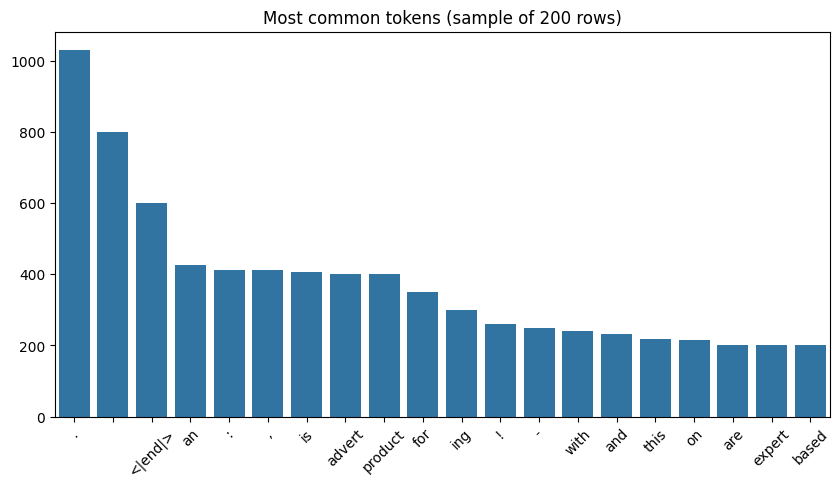


🔎 Decoded back sample:
You are an expert marketing copywriter. Create engaging advertisements based on product information.
 Product: Harem pants
Description: A style of pants with a dropped crotch, loose-fitting legs, and a gathered waistband for a unique, bohemian look.
Create an advertisement for this product.
 Discove...


In [8]:
from collections import Counter


# ===== VISUALIZATION: TOKENIZED DATA =====
print("\n🔎 Tokenized sample (first 30 tokens):")
print(processed_dataset[0]["input_ids"][:30])

# Histogram of sequence lengths before padding
seq_lengths = [sum(1 for t in ex["input_ids"] if t != tokenizer.pad_token_id)
               for ex in processed_dataset]
plt.figure(figsize=(6,4))
sns.histplot(seq_lengths, bins=40, kde=False)
plt.title("Sequence lengths (non-padding tokens)")
plt.show()

# Token frequency distribution
all_tokens = []
all_tokens = []
for ex in processed_dataset.select(range(200)):  # returns Dataset subset
    all_tokens.extend([t for t in ex["input_ids"] if t != tokenizer.pad_token_id])
counter = Counter(all_tokens)
most_common = counter.most_common(20)

tokens, counts = zip(*most_common)
plt.figure(figsize=(10,5))
sns.barplot(x=[tokenizer.decode([t]) for t in tokens], y=counts)
plt.title("Most common tokens (sample of 200 rows)")
plt.xticks(rotation=45)
plt.show()

# Sanity check
sample = processed_dataset[0]
decoded = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
print(f"\n🔎 Decoded back sample:\n{decoded[:300]}...")

### Training

In [9]:
# ==============================================================
# TRAINING ARGS
# ==============================================================
training_args = TrainingArguments(
    output_dir="./phi3-product-ads",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=100,
    learning_rate=2e-4,
    logging_steps=10,
    logging_first_step=True,       # log first step
    eval_strategy="no",
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    gradient_checkpointing=True,
    remove_unused_columns=False,
    report_to=["mlflow"],          # MLflow logging enabled
    fp16=True,
    dataloader_pin_memory=False,
)


data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

In [18]:
# ==============================================================
# TRAINING
# ==============================================================
experiment_name = "phi3-ad-generation"
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_params({
        "model_name": model_name,
        "dataset_size": len(processed_dataset),
        "lora_r": 16,
        "lora_alpha": 32,
        "learning_rate": 2e-4,
        "num_epochs": 3,
        "batch_size": 2,
        "gradient_accumulation_steps": 8,
        "max_length": 512,
        "data_source": "local_json",
    })

    trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=processed_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )
    print("Starting training with MLflow tracking...")
    trainer.train()

    # ==========================================================
    # Save only LoRA adapters (small size)
    # ==========================================================
    lora_path = os.path.join(".", "phi3-product-ads-lora")
    peft_model.save_pretrained(lora_path)
    tokenizer.save_pretrained(lora_path)

    # Log only adapter weights + tokenizer
    mlflow.log_artifacts(lora_path, artifact_path="lora_adapter")

    print("✅ Training complete. LoRA adapter and tokenizer logged to MLflow.")


/tmp/ipython-input-3501709179.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training with MLflow tracking...


Step,Training Loss
1,2.238900
10,2.180800
20,1.979800
30,1.658800
40,1.096800
50,0.754200
60,0.641500
70,0.616700
80,0.596300
90,0.545500


2025/09/07 13:21:47 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id f6905ab9ab5c46d8a3f38ad317441220: Failed to log run data: Exception: API request to https://f96dffc4d84a.ngrok-free.app/api/2.0/mlflow/runs/log-batch failed with exception HTTPSConnectionPool(host='f96dffc4d84a.ngrok-free.app', port=443): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError('too many 500 error responses'))


✅ Training complete. LoRA adapter and tokenizer logged to MLflow.
🏃 View run bittersweet-sow-565 at: https://f96dffc4d84a.ngrok-free.app/#/experiments/633517257330426464/runs/f6905ab9ab5c46d8a3f38ad317441220
🧪 View experiment at: https://f96dffc4d84a.ngrok-free.app/#/experiments/633517257330426464


### Test

In [4]:
from peft import PeftModel

# =============================================================================
# TEXT AD GENERATION
# =============================================================================

class TextAdGenerator:
    """Generate text advertisements using the fine-tuned model"""

    def __init__(self, model_path, tokenizer_path=None):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path or model_path
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """Load the fine-tuned LoRA adapter with the base model"""
        print("Loading fine-tuned LoRA model...")
        clear_memory()

        # Load tokenizer from base model
        self.tokenizer = AutoTokenizer.from_pretrained(
            "microsoft/Phi-3-mini-4k-instruct",
            trust_remote_code=True
        )

        # Load base model
        base_model = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-3-mini-4k-instruct",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
            low_cpu_mem_usage=True,
            max_memory={0: "8GiB"},
        )

        # Apply LoRA adapter
        self.model = PeftModel.from_pretrained(base_model, self.model_path)

        print("✅ LoRA fine-tuned model loaded successfully!")

    def generate_ad(self, product_name, product_description, max_length=512, temperature=0.7):
        """Generate advertisement text for a product"""
        # Format the prompt (shorter format for memory efficiency)
        prompt = (
            f"Product: {product_name}\n"
            f"Description (summary): {product_description[:300]}\n"
            f"Task: Write a compelling advertisement under 100 words. "
            f"Focus on benefits, keep it clear and engaging.\nAd:"
        )

        # Tokenize
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        # Generate with memory-conscious settings
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=temperature,
                do_sample=True,
                top_p=0.9,
                top_k=50,
                pad_token_id=self.tokenizer.eos_token_id,
                repetition_penalty=1.1,
                use_cache=False,  # Disable cache to avoid seen_tokens issue
                past_key_values=None  # Explicitly set to None
            )

        # Decode and clean up
        full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        ad_text = full_response.split("Ad:")[-1].strip()

        return ad_text

In [5]:
# =============================================================================
# SECTION 8: MEMORY-OPTIMIZED PIPELINE
# =============================================================================

class ProductAdPipeline:
    """Complete pipeline for product ad generation with memory management"""

    def __init__(self, text_model_path):
        self.text_model_path = text_model_path
        self.text_generator = None

    def generate_complete_ad(self, product_name, product_description):
        """Generate text advertisement with memory management"""
        print(f"Generating complete ad for: {product_name}")

        # Step 1: Generate text ad
        if self.text_generator is None:
            self.text_generator = TextAdGenerator(self.text_model_path)
            self.text_generator.load_model()

        ad_text = self.text_generator.generate_ad(product_name, product_description)


        return {
            "product_name": product_name,
            "product_description": product_description,
            "ad_text": ad_text,
        }

In [6]:
import torch

pipeline = ProductAdPipeline("./phi3-product-ads-lora")

# Example generation
test_product = "Wireless Bluetooth Headphones"
test_description = "High-quality wireless headphones with noise cancellation and long battery life."

result = pipeline.generate_complete_ad(
    test_product,
    test_description,

)

print(f"Generated ad text: {result['ad_text']}")

Generating complete ad for: Wireless Bluetooth Headphones
Loading fine-tuned LoRA model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ LoRA fine-tuned model loaded successfully!


Generated ad text: Experience comfort like never before! Our Noise Cancelling Earbuds deliver crystal-clear sound & silence the world around you – perfect for work or play.


In [16]:
# To export the lora weights
!zip -r phi3-product-ads-lora.zip phi3-product-ads-lora

  adding: phi3-product-ads-lora/ (stored 0%)
  adding: phi3-product-ads-lora/tokenizer.json (deflated 85%)
  adding: phi3-product-ads-lora/adapter_config.json (deflated 57%)
  adding: phi3-product-ads-lora/chat_template.jinja (deflated 60%)
  adding: phi3-product-ads-lora/README.md (deflated 65%)
  adding: phi3-product-ads-lora/special_tokens_map.json (deflated 79%)
  adding: phi3-product-ads-lora/tokenizer_config.json (deflated 86%)
  adding: phi3-product-ads-lora/added_tokens.json (deflated 62%)
  adding: phi3-product-ads-lora/tokenizer.model (deflated 55%)
  adding: phi3-product-ads-lora/adapter_model.safetensors (deflated 7%)


In [17]:
# To move the zipped wheights to the google drive, mount the drive first
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### API

In [7]:
!ngrok config add-authtoken <Token>

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [8]:
# =====================================================
# STEP 2: Import libraries
# =====================================================
import torch
import nest_asyncio
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
from pyngrok import ngrok
import requests

from transformers import AutoTokenizer, AutoModelForCausalLM

In [9]:
# =====================================================
# STEP 3: Define your Text Ad Generator
# =====================================================
class TextAdGenerator:
    def __init__(self, model_path, tokenizer_path=None):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path or model_path
        self.model = None
        self.tokenizer = None

    def load_model(self):
        """Load the fine-tuned LoRA adapter with the base model"""
        print("Loading fine-tuned LoRA model...")
        clear_memory()

        # Load tokenizer from base model
        self.tokenizer = AutoTokenizer.from_pretrained(
            "microsoft/Phi-3-mini-4k-instruct",
            trust_remote_code=True
        )

        # Load base model
        base_model = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-3-mini-4k-instruct",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
            low_cpu_mem_usage=True,
            max_memory={0: "8GiB"},
        )

        # Apply LoRA adapter
        self.model = PeftModel.from_pretrained(base_model, self.model_path)

        print("✅ LoRA fine-tuned model loaded successfully!")

    def generate_ad(self, product_name, product_description, max_length=128, temperature=0.7):
        prompt = (
            f"Product: {product_name}\n"
            f"Description (summary): {product_description[:300]}\n"
            f"Task: Write a compelling advertisement under 100 words.\nAd:"
        )
        inputs = self.tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_length,
                temperature=temperature,
                do_sample=True,
                top_p=0.9,
                top_k=50,
                pad_token_id=self.tokenizer.eos_token_id,
                repetition_penalty=1.1,
                use_cache=False,
            )

        full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        ad_text = full_response.split("Ad:")[-1].strip()
        return ad_text


class ProductAdPipeline:
    def __init__(self, text_model_path):
        self.text_model_path = text_model_path
        self.text_generator = None

    def generate_complete_ad(self, product_name, product_description):
        if self.text_generator is None:
            self.text_generator = TextAdGenerator(self.text_model_path)
            self.text_generator.load_model()
        ad_text = self.text_generator.generate_ad(product_name, product_description)
        return {
            "product_name": product_name,
            "product_description": product_description,
            "ad_text": ad_text,
        }

In [14]:
from fastapi.middleware.cors import CORSMiddleware

# =====================================================
# STEP 4: FastAPI setup
# =====================================================
app = FastAPI()
pipeline = ProductAdPipeline("./phi3-product-ads-lora")

# Allow all origins (for testing/development)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class ProductRequest(BaseModel):
    product_name: str
    product_description: str

@app.post("/generate-ad")
def generate_ad(request: ProductRequest):
    result = pipeline.generate_complete_ad(request.product_name, request.product_description)
    return result


In [15]:
# =====================================================
# STEP 5: Start API with ngrok
# =====================================================
nest_asyncio.apply()

# Open ngrok tunnel
public_url = ngrok.connect(8000)
print("🚀 Public URL:", public_url)

# Run server
config = uvicorn.Config(app=app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config)
await server.serve()

🚀 Public URL: NgrokTunnel: "https://7529711559b2.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [23877]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Loading fine-tuned LoRA model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅ LoRA fine-tuned model loaded successfully!
INFO:     2402:d000:a500:4aa4:3590:9542:a87f:fa69:0 - "POST /generate-ad HTTP/1.1" 200 OK
INFO:     2402:d000:a500:4aa4:3590:9542:a87f:fa69:0 - "OPTIONS /generate-ad HTTP/1.1" 200 OK
INFO:     2402:d000:a500:4aa4:3590:9542:a87f:fa69:0 - "POST /generate-ad HTTP/1.1" 200 OK
INFO:     2402:d000:a500:4aa4:3590:9542:a87f:fa69:0 - "POST /generate-ad HTTP/1.1" 200 OK
INFO:     2402:d000:a500:4aa4:3590:9542:a87f:fa69:0 - "POST /generate-ad HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [23877]
